In [1]:
%run nbloader.py
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import math
import numpy as np


BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000
dZ = 205


In [2]:
from read_opera_bg import load_bg;
from read_opera_mc import load_mc;
from read_opera_bg import plot_bg
pbg = load_bg(step=50);
pmc = load_mc(step=1);

importing notebook from read_opera_bg.ipynb
bg: 2767 tracks
len(slopes): 2767
importing notebook from read_opera_mc.ipynb
numtracks reduction by cuts:  [188, 186, 109, 50, 19, 19]
len(slopes): 731
bg: 546462 tracks
numtracks reduction by cuts:  [18724, 18678, 11058, 5389, 2799, 2684]


## Описание работы алгоритма

Для каждого трека первой пластины алгортим находит ближайшего соседа на на следующей пластине. Если сосед ближе чем заранее установленная граница, то он помечает его как продолжение данного трека, запоминает номер родителя и его номер в последовательности. На следующем слое алгоритм запускается только на треках для которых нашелся сосед на предыдущей итерации.

In [3]:
def find_similar(track, data_to_clear):
    threshold = 0.001
    dist = distance(track, data_to_clear)
    result = min(dist)

    if result < threshold:
        return dist.argmin()
    return False

def distance(track, other):
    track = np.array(track[0:5], dtype = float)
    distance = (track[0] - other[:, 0])**2 + (track[1] - other[:, 1])**2 + (track[2] - other[:, 2])**2
    distance = distance**(0.5)
    angle = 1/(np.sqrt((track[3]-other[:, 3])**2 + (track[4]-other[:, 4])**2 + 1))
    rad_angle = np.arccos(angle)
    tan_angle = np.tan(rad_angle)
    
    track_begin = track[0:3]
    
    track_end = np.copy(track_begin)
    track_end[0] += dZ * track[3]
    track_end[1] += dZ * track[4]
    track_end[2] += dZ

    IP = np.linalg.norm(np.cross(other[:, 0:3] - track_end, other[:, 0:3] - track_begin), axis = 1)/np.linalg.norm(track_end - track_begin)
    
    result = metrics(distance / dZ, tan_angle, IP / dZ, 1)
    return result

def metrics(distance, tan_angle, IP, C):
    result = (0*  distance / 210)**2 + (0 * tan_angle /2)**2 + (7 * IP / 210)**2
    return result

            
def clear_layer(to_clear, to_compare):
    indexes = to_compare.index
    for index, track in to_clear.iterrows():
        result = find_similar(track, np.asarray(to_compare))
        if (result == False):
            #if to_clear.number_of_ancestors[index] < 5:
            to_clear = to_clear.drop(index) # but number of parents can be high! 
        else:
            to_compare.set_value(indexes[result], 'number_of_ancestors', track[7] + 1)
            to_compare.set_value(indexes[result], 'parent_index', index)
    to_compare = to_compare[to_compare.number_of_ancestors > 0]
    return pd.concat([to_clear, to_compare])


def find_shower(data, values_of_z):
    first_layer = data[data['s.eZ'] == values_of_z[0]]
    second_layer = data[data['s.eZ'] == values_of_z[1]]
    
    result = clear_layer(first_layer, second_layer)
    
    
    return result

def complete_shower_finder(data):
    layers = list(set(data['s.eZ']))
    layers.sort()
    for n in range(1):
        for i in range(len(layers) - 1):
            data_to_clear = data[data['s.eZ'].isin(layers[i: i + 2])]
            cleared_data = find_shower(data_to_clear, layers[i: i + 2])
            data = data.drop(data.index[data['s.eZ'].isin(layers[i: i + 2])])
            data = pd.concat([data, cleared_data])
    data = data.drop(data.index[data['s.eZ'].isin([layers[len(layers) - 1]])]) # drop last layer
    return data

def plot_distance_angle(track, layer, color):
    other = layer

    track = np.array(track[0:5], dtype = float)
    distance = (track[0] - other[:, 0])**2 + (track[1] - other[:, 1])**2 + (track[2] - other[:, 2])**2
    distance = distance**(0.5)
    angle = 1/(np.sqrt((track[3]-other[:, 3])**2 + (track[4]-other[:, 4])**2 + 1))
    rad_angle = np.arccos(angle)
    tan_angle = np.tan(rad_angle)
    '''
    track_begin = track[0:3]
    
    track_end = np.copy(track_begin)
    track_end[0] += dZ * track[3]
    track_end[1] += dZ * track[4]
    track_end[2] += dZ

    IP = np.linalg.norm(np.cross(other[:, 0:3] - track_end, other[:, 0:3] - track_begin), axis = 1)/np.linalg.norm(track_end - track_begin)
    '''
    
    plt.scatter(distance / dZ, tan_angle, color =color)

In [4]:
def plot_pairs(d0, d1, df):
    dZ = 205

    # mind the order!
    d00 = pd.DataFrame([
                df['s.eZ'][:],
                df['s.eX'][:],
                df['s.eY'][:]],
                index=['z', 'x', 'y']).T
    numtracks = d00.shape[0]
    dd = pd.DataFrame([
            df['s.eTX'][:]*dZ,
            df['s.eTY'][:]*dZ],
            index=['x', 'y']).T
    dd.insert(loc=0, column='z', value=dZ)
    d11 = d00 + dd

    C = plt.cm.Blues(0.5)
    lc = Line3DCollection(zip(d00.values, d11.values), colors=C, alpha=0.5, lw=2)
    numtracks = len(d0[:, 0])
    

    C = plt.cm.Reds(0.5)
    lb = Line3DCollection(zip(d0[:, [2, 0, 1]], d1[:, [2, 0, 1]]), colors=C, alpha=0.9, lw=2)

    fig = plt.figure(figsize=(12,8))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=-103, elev=16)
    ax.add_collection3d(lc)
    ax.add_collection3d(lb)

    ax.set_xlabel("z")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    ax.set_xlim(d0[:, 2].min(), d0[:, 2].max())
    ax.set_ylim(d0[:, 0].min(), d0[:, 0].max())
    ax.set_zlim(d0[:, 1].min(), d0[:, 1].max())


In [5]:
z_coordinates = list(set(pbg['s.eZ']))
z_coordinates.sort()
def f(x): return x > 60000
z_coordinates = filter(f, z_coordinates)

In [6]:
data_to_clear = pbg[pbg['s.eZ'].isin(z_coordinates)]
data_to_clear = data_to_clear.apply(np.random.permutation)
data_to_clear['signal'] = 0
data_to_clear = data_to_clear[:30000]

In [7]:
for i in range(15):
    my_shower = pmc.iloc[i]
    shower_frame = pd.DataFrame([
                my_shower['BT_X'],
                my_shower['BT_Y'],
                my_shower['BT_Z'] - my_shower['BT_Z'] % 1293,
                my_shower['BT_SX'],
                my_shower['BT_SY']],
                index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']).T
    shower_frame['signal'] = 1
    shower_frame['s.eChi2'] = 0
    
    shower_frame = shower_frame[shower_frame['s.eZ'].isin(z_coordinates)]
    index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 'signal', 's.eChi2']
    testing_data = pd.concat([shower_frame, data_to_clear])
    testing_data = testing_data[index]
    testing_data['number_of_ancestors'] = 0
    testing_data['parent_index'] = -1
    cleared_data = complete_shower_finder(testing_data)
    print "Original shower size: " + str(len(shower_frame))
    print "Cleared shower size: " + str(sum(cleared_data.signal == 1))
    print "Uncleared noise: " + str(sum(cleared_data.signal == 0))

Original shower size: 49
Cleared shower size: 5
Uncleared noise: 384
Original shower size: 154
Cleared shower size: 54
Uncleared noise: 384
Original shower size: 41
Cleared shower size: 1
Uncleared noise: 385
Original shower size: 18
Cleared shower size: 4
Uncleared noise: 384
Original shower size: 235
Cleared shower size: 76
Uncleared noise: 385
Original shower size: 5
Cleared shower size: 0
Uncleared noise: 384
Original shower size: 47
Cleared shower size: 2
Uncleared noise: 385
Original shower size: 15
Cleared shower size: 0
Uncleared noise: 384
Original shower size: 19
Cleared shower size: 3
Uncleared noise: 385
Original shower size: 106
Cleared shower size: 38
Uncleared noise: 384
Original shower size: 10
Cleared shower size: 0
Uncleared noise: 384
Original shower size: 24
Cleared shower size: 4
Uncleared noise: 384
Original shower size: 87
Cleared shower size: 21
Uncleared noise: 384
Original shower size: 81
Cleared shower size: 6
Uncleared noise: 384
Original shower size: 122
Cl

len(slopes): 460


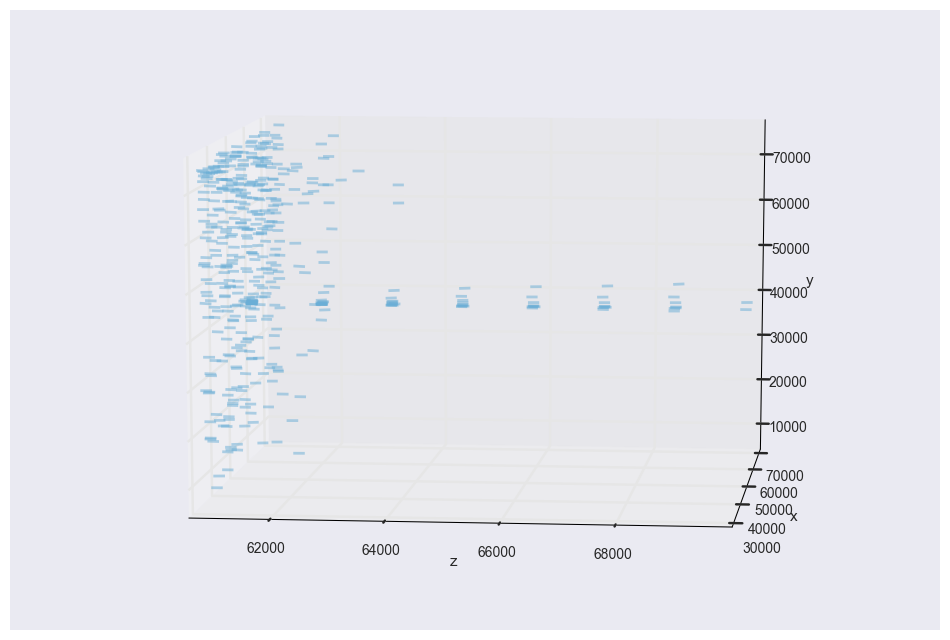

In [8]:
%matplotlib inline
plot_bg(cleared_data);

In [9]:
my_shower = pmc.iloc[14]
shower_frame = pd.DataFrame([
                my_shower['BT_X'],
                my_shower['BT_Y'],
                my_shower['BT_Z'] - my_shower['BT_Z'] % 1293,
                my_shower['BT_SX'],
                my_shower['BT_SY']],
                index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']).T
shower_frame['signal'] = 1
shower_frame['s.eChi2'] = 0

shower_frame = shower_frame[shower_frame['s.eZ'].isin(z_coordinates)]
testing_data = pd.concat([shower_frame, data_to_clear])
index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 'signal', 's.eChi2']
testing_data = testing_data[index]

In [10]:
first = testing_data[testing_data['s.eZ'] == z_coordinates[0]]
signal = first.iloc[10]
noise = first.iloc[1000]
layer = testing_data[testing_data['s.eZ'] == z_coordinates[1]]
color = layer.loc[:, 'signal']
layer = np.asarray(layer)
color.loc[color == 1] = 'red'
color.loc[color == 0] = 'blue'


/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


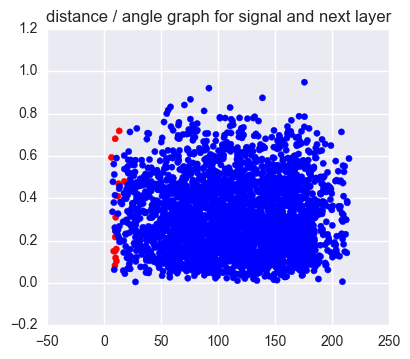

In [11]:
plt.figure(figsize=(15, 13))
n = 1
for i in range(0,1):
    plt.subplot(3, 3, n)
    n += 1
    signal = first.iloc[i]
    plot_distance_angle(signal, layer, color)
    plt.title("distance / angle graph for signal and next layer")


In [12]:
layer = testing_data[testing_data['s.eZ'] == z_coordinates[2]]
color = layer.loc[:, 'signal']
layer = np.asarray(layer)
color.loc[color == 1] = 'red'
color.loc[color == 0] = 'blue'


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


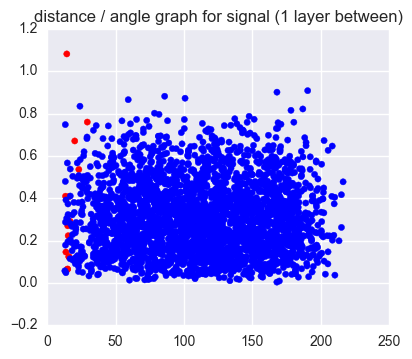

In [13]:
plt.figure(figsize=(15, 13))
n = 1
for i in range(0,1):
    plt.subplot(3, 3, n)
    n += 1
    signal = first.iloc[i]
    plot_distance_angle(signal, layer, color)
    plt.title("distance / angle graph for signal (1 layer between)")

Что ещё можно сделать:
    1. Натренировать логит регрессию вместо использования метрики (либо просто запустить поиск по сетке с перебором различных весов для фич)
    2. Учитывать несколько слоев одновременно (нужно?)
    3. Удалять короткие последовательности (либо просто пройтись алгоритмом в обратную сторону)
    4. Вычислять дистанцию с поправкой на угол относительно оси z (некоторые shower идут под углом, расстояние между треками растет и они отсеиваются)

Как должна работать логит -- регрессия? Построим датасет, где единицами обозначим вектор из расстояния, угла и импакт параметра соответствующего одной и той же частице на двух соседних слоях и за 0 обозначим всё остальное. Далее, во время работы алгоритма, мы смотрим, есть ли продолжение для данного трека с высокой вероятностью, и если есть обозначаем его как потомка нашего трека.

Чтобы построить такой дата - сет, нужно правильно соотнести продолжение каждого трека на следующей пластине. Полезным в таком случае оказывается импакт параметр.

In [14]:
my_shower = pmc.iloc[14]
shower_frame = pd.DataFrame([
        my_shower['BT_X'],
        my_shower['BT_Y'],
        my_shower['BT_Z'] - my_shower['BT_Z'] % 1293,
        my_shower['BT_SX'],
        my_shower['BT_SY']],
        index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']).T
shower_frame['signal'] = 1
shower_frame['s.eChi2'] = 0

z_coordinates = list(set(pbg['s.eZ']))
z_coordinates.sort()
def f(x): return x > 60000
z_coordinates = filter(f, z_coordinates)

shower_frame = shower_frame[shower_frame['s.eZ'].isin(z_coordinates)]

In [15]:
numpy_frame = np.asarray(shower_frame)
parents = list()
sons = list()
for i in range(len(z_coordinates)):
    for track in numpy_frame[numpy_frame[:, 2] == z_coordinates[i] ,:]:
        next_layer = numpy_frame[numpy_frame[:, 2] == z_coordinates[i + 1] ,:]
        dist = distance(track, next_layer)
        if (len(dist) != 0 and dist.min() < 0.001):
            parents.append(track)
            sons.append(next_layer[dist.argmin(), :])

In [16]:
sons = np.asarray(sons)
parents = np.asarray(parents)

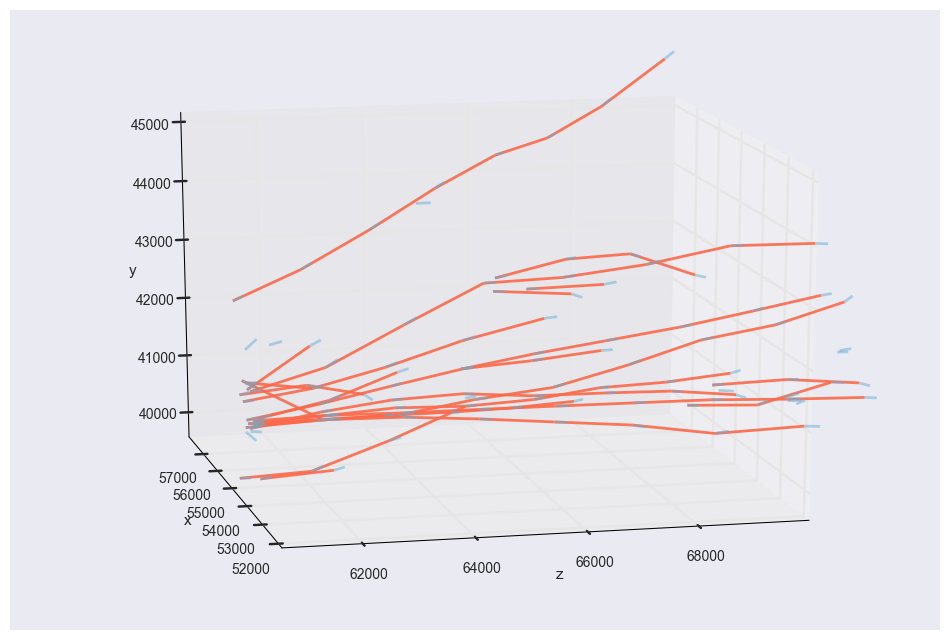

In [17]:
plot_pairs(parents, sons, shower_frame)

На примере душа с id = 0, мы видим, что зачастую, частица может фиксироваться позднее и не находится на первой пластине. Это означает, что нельзя отбрасывать кандидатов для которых не нашлись предки на первой пластине. В тоже время это увеличит количество неотсеянного шума, следовательно нужна более качетственная метрика.